<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Solution-Summary" data-toc-modified-id="Solution-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Solution Summary</a></span></li><li><span><a href="#Load-Data-and-Function-Definitions" data-toc-modified-id="Load-Data-and-Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data and Function Definitions</a></span></li><li><span><a href="#Grouping-Base-Stations" data-toc-modified-id="Grouping-Base-Stations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grouping Base Stations</a></span></li><li><span><a href="#Pseudo-Labeling" data-toc-modified-id="Pseudo-Labeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pseudo Labeling</a></span><ul class="toc-item"><li><span><a href="#Label-Type11" data-toc-modified-id="Label-Type11-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Label Type11</a></span></li><li><span><a href="#Label-Type12" data-toc-modified-id="Label-Type12-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Label Type12</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Training-for-seen-stations" data-toc-modified-id="Training-for-seen-stations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training for seen stations</a></span><ul class="toc-item"><li><span><a href="#The-importance-of-all-27-features" data-toc-modified-id="The-importance-of-all-27-features-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>The importance of all 27 features</a></span></li></ul></li><li><span><a href="#Training-for-unseen-stations" data-toc-modified-id="Training-for-unseen-stations-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training for unseen stations</a></span><ul class="toc-item"><li><span><a href="#Top-10-important-features" data-toc-modified-id="Top-10-important-features-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Top 10 important features</a></span></li></ul></li><li><span><a href="#Submission" data-toc-modified-id="Submission-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 800)
pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings("ignore")

import random
from sklearn.linear_model import HuberRegressor, LinearRegression

## Solution Summary

* Not use any historical and future data.
* Use less than 30 easy features, including configuration settings, load, hour and day. Complicated features such as aggregation, frequency encoding, target encoding can introduce leakage of future info.
* Train separate models for seen rutypes and unseen rutypes stations.
* Pseudo labeling 3 stations of Type11 and Type12 based on assumptions learned from EDA and analytic models from linear regression.

## Load Data and Function Definitions

* Only use provide data
* Only need sklearn and lightgbm packages

In [2]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

bsinfo_raw = pd.read_csv('data/BSinfo.csv')
cell_raw = pd.read_csv('data/CLdata.csv')
energy_raw = pd.read_csv('data/ECdata.csv')
test_raw = pd.read_csv('data/test.csv')

bsinfo = rename_columns(bsinfo_raw)
cell = rename_columns(cell_raw)
energy = rename_columns(energy_raw)
test = rename_columns(test_raw)

In [3]:
cell['time'] = pd.to_datetime(cell['time'])
energy['time'] = pd.to_datetime(energy['time'])
test['time'] = pd.to_datetime(test['time'])

#esmode4 is never used, esmode5 only used in 3 instances.
cell = cell.drop(['esmode4','esmode5'],axis=1).sort_values('time')
energy = energy.sort_values('time')
test = test.sort_values('time')

In [4]:
#use cell0 info as the basics
bsinfo_agg = bsinfo.groupby(['bs']).agg({'mode':'first','rutype':'first','bs':'size'}).rename({'bs':'cell_count'},axis=1)
bsinfo_agg = bsinfo_agg.join(bsinfo[bsinfo['cellname']=='Cell0'].groupby(['bs'])['antennas','txpower','frequency','bandwidth'].first())
bsinfo_agg['antenna-txpower'] = bsinfo_agg['antennas'].astype(str)+'-'+np.round(bsinfo_agg['txpower'],1).astype(str)
bsinfo_agg['freq-band'] = bsinfo_agg['frequency'].astype(str)+'-'+bsinfo_agg['bandwidth'].astype(str)

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,TimeSeriesSplit,GroupKFold
from sklearn.metrics import mean_squared_error,roc_curve, auc, confusion_matrix, r2_score, mean_absolute_error 

def lgbm_cv(train_df, target, features, n_splits = 5, groups=None, params=None, random_state=42, shuffle=True, sample_weight=None, kfold = True,verbose=True):        
    models = []    
    
    if groups is None:
        if kfold:
            folds = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        else:
            folds = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    else:
        folds = GroupKFold(n_splits=n_splits)
        
    oof = np.zeros(len(train_df))  
    fold = np.zeros(len(train_df))        
    feature_importance_df = pd.DataFrame()
    fold_scores = []
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target,groups)):
        if verbose: print('fold:'+ str(fold_))
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target[val_idx])

        if sample_weight is not None:
            trn_data.set_weight(sample_weight[trn_idx])
            val_data.set_weight(sample_weight[val_idx])
        if verbose:    
            verbose_eval = 5000
        else:
            verbose_eval = -1
            
        clf = lgb.train(params, trn_data, 50000, valid_sets = [trn_data, val_data], verbose_eval=verbose_eval, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        fold_scores.append(mean_absolute_error(target[val_idx],oof[val_idx]))        
        
        models.append(clf)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values('importance',ascending=False)    
    return feature_importance_df, oof, models,fold_scores 

## Grouping Base Stations 

* Grouping from configuration perspective, find nearest neighbors with same settings for each station

In [6]:
bsinfo['txpower_round'] = bsinfo['txpower'].round(2)
#nearest neighbor dataframe
nn_df = pd.DataFrame(index=bsinfo['bs'].unique())

#single cell
for bs in bsinfo_agg[bsinfo_agg['cell_count']==1].index.values:    
    bs_dict = bsinfo[(bsinfo['bs']==bs) & (bsinfo['cellname']=='Cell0')].to_dict('records')[0]    
    bs_array = bsinfo[(bsinfo['bs'].isin(bsinfo_agg[bsinfo_agg['cell_count']==1].index))
       & (bsinfo['cellname']=='Cell0') & (bsinfo['rutype']==bs_dict['rutype']) & (bsinfo['frequency']==bs_dict['frequency']) 
       & (bsinfo['bandwidth']==bs_dict['bandwidth']) & (bsinfo['antennas']==bs_dict['antennas'])
       & (bsinfo['txpower_round']==bs_dict['txpower_round'])]['bs'].values        
    nn_df.at[bs,'config'] = bs_array    

#double cells
for bs in bsinfo_agg[bsinfo_agg['cell_count']==2].index.values:        
    bs_dict = bsinfo[(bsinfo['bs']==bs) & (bsinfo['cellname']=='Cell0')].to_dict('records')[0]    
    bs_array_cell0 = bsinfo[(bsinfo['bs'].isin(bsinfo_agg[bsinfo_agg['cell_count']==2].index))
       & (bsinfo['cellname']=='Cell0') & (bsinfo['rutype']==bs_dict['rutype']) & (bsinfo['frequency']==bs_dict['frequency']) 
       & (bsinfo['bandwidth']==bs_dict['bandwidth']) & (bsinfo['antennas']==bs_dict['antennas'])
       & (bsinfo['txpower_round']==bs_dict['txpower_round'])]['bs'].values
    
    bs_dict = bsinfo[(bsinfo['bs']==bs) & (bsinfo['cellname']=='Cell1')].to_dict('records')[0]    
    bs_array_cell1 = bsinfo[(bsinfo['bs'].isin(bsinfo_agg[bsinfo_agg['cell_count']==2].index))
       & (bsinfo['cellname']=='Cell1') & (bsinfo['rutype']==bs_dict['rutype']) & (bsinfo['frequency']==bs_dict['frequency']) 
       & (bsinfo['bandwidth']==bs_dict['bandwidth']) & (bsinfo['antennas']==bs_dict['antennas'])
       & (bsinfo['txpower_round']==bs_dict['txpower_round'])]['bs'].values
    
    nn_df.at[bs,'config'] = np.intersect1d(bs_array_cell0,bs_array_cell1)     
    
#four cells
nn_df.at['B_105','config'] = ['B_105','B_745']
nn_df.at['B_745','config'] = ['B_105','B_745']

#convert to categorical column
nn_df['config_group'] = nn_df['config'].astype(str).astype('category')

## Pseudo Labeling

* Type11 and Type12 are almost brand new rutypes (only 1 sample for each type in train)
* We pseudo label three base stations based on assumptions learned from EDA and analytic models (a separate notebook).

In [7]:
regression_df = cell.merge(energy,how='left',left_on=['bs','time'],right_on=['bs','time'])
regression_df = regression_df[(regression_df['energy'].notna())]

energy_new = pd.DataFrame()

def plot_base(bs, time, load, energy):    
    plt.figure(figsize=(12,2))
    plt.plot(time, load*100, label='load*100')
    plt.plot(time, energy,label='energy filled')    
    plt.title(bs)
    plt.legend(loc='lower right')
    plt.show()    

### Label Type11

In [8]:
bs_list = bsinfo[(bsinfo['rutype']=='Type10') & (bsinfo['txpower']>8.046)]['bs'].unique()

reg = regression_df[(regression_df['bs'].isin(bs_list)) & ((regression_df['load']<0.1))]
X = reg['load'].values.reshape(-1, 1)
y = reg['energy']

linear11_low = LinearRegression().fit(X, y)
print(linear11_low.score(X, y), linear11_low.coef_, linear11_low.intercept_)

reg = regression_df[(regression_df['bs'].isin(bs_list)) & ((regression_df['load']>0.1))]
X = reg['load'].values.reshape(-1, 1)
y = reg['energy']
linear11_high = LinearRegression().fit(X, y)
print(linear11_high.score(X, y), linear11_high.coef_, linear11_high.intercept_)

0.5348843272642081 [116.51287644] 8.530325173491203
0.948328142652739 [57.76838916] 21.225577985414347


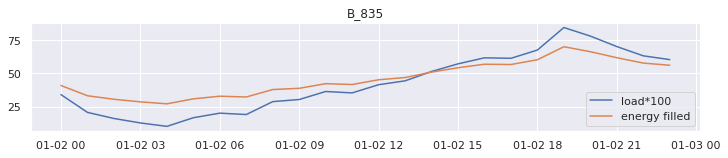

In [9]:
bs = 'B_835'
base = cell[(cell['bs']==bs)] 
energy_filled = linear11_high.predict(base['load'].values.reshape(-1, 1))

#append to new energy dataframe
energy_bs = test[test['bs']==bs].copy()
energy_bs['energy'] = energy_filled[1:]
energy_new = energy_new.append(energy_bs[['time','bs','energy']])

plot_base(bs,base['time'].values,base['load'].values,energy_filled)

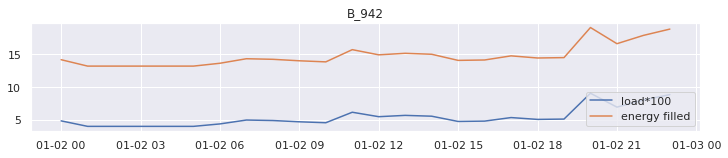

In [10]:
bs= 'B_942'
base = cell[(cell['bs']==bs)] 
energy_filled = linear11_low.predict(base['load'].values.reshape(-1, 1))

#append to new energy dataframe
energy_bs = test[test['bs']==bs].copy()
energy_bs['energy'] = energy_filled
energy_new = energy_new.append(energy_bs[['time','bs','energy']])

plot_base(bs,base['time'].values,base['load'].values,energy_filled)

### Label Type12

In [11]:
bs_list = bsinfo[(bsinfo['rutype']=='Type10') & (bsinfo['txpower']<8.04)]['bs'].unique()

reg = regression_df[(regression_df['bs'].isin(bs_list)) & ((regression_df['load']<0.1))]
X = reg['load'].values.reshape(-1, 1)
y = reg['energy']
linear_low = LinearRegression().fit(X, y)
print(linear_low.score(X, y), linear_low.coef_, linear_low.intercept_)

reg = regression_df[(regression_df['bs'].isin(bs_list)) & ((regression_df['load']>0.2))]
X = reg['load'].values.reshape(-1, 1)
y = reg['energy']
linear_high = LinearRegression().fit(X, y)
print(linear_high.score(X, y), linear_high.coef_, linear_high.intercept_)

0.7142814180947457 [933.3469351] -46.20431057655082
0.9672480290388377 [58.38486187] 33.71710758397835


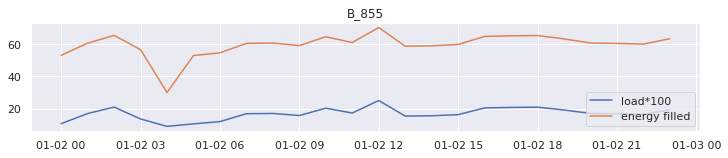

In [12]:
bs= 'B_855'
base = cell[(cell['bs']==bs)].merge(energy,how='left',left_on=['bs','time'],right_on=['bs','time'])  
energy_filled = []
for val in base['load'].values:
    if val>0.1: 
        energy_filled.append(val*120+40)
    else:
        energy_filled.append(30)        

#append to new energy dataframe
energy_bs = test[test['bs']==bs].copy()
energy_bs['energy'] = energy_filled
energy_new = energy_new.append(energy_bs[['time','bs','energy']])

plot_base(bs,base['time'].values,base['load'].values,energy_filled)      

## Preprocessing

In [13]:
#list of seen and unseen base stations
unseen_bs = test['bs'].unique()[~np.isin(test['bs'].unique(),energy['bs'].unique())].tolist()+['B_854','B_835']
seen_bs = test[~test['bs'].isin(unseen_bs)]['bs'].unique().tolist()

#pivot the table to align the cell0, cell1
cell = cell.merge(bsinfo[['frequency','bandwidth','antennas', 'txpower','bs','cellname']], how='left', on =['bs','cellname'])
cell_pivot = cell.pivot(index=['time','bs'], columns='cellname')
cell_pivot.columns = [x[1]+'_'+x[0] for x in cell_pivot.columns]
cell_pivot = cell_pivot.reset_index()
cell_pivot = cell_pivot.drop([x for x in cell_pivot.columns if x.find('Cell2')==0 or x.find('Cell3')==0], axis=1)

print(cell_pivot.shape)

(118768, 20)


In [14]:
#merge cell, energy and config group together
all_df = cell_pivot.merge(bsinfo_agg[['mode','rutype','cell_count','antenna-txpower','freq-band']], how='left', left_on='bs', right_index=True)
all_df = all_df.merge(nn_df[['config_group']], how='left', left_on='bs', right_index=True)
all_df = all_df.merge(pd.concat([energy,energy_new]), how='left', left_on=['time','bs'], right_on=['time','bs'])

#categorical features
all_df['hour'] = all_df['time'].dt.hour.astype('category')
all_df['day'] = all_df['time'].dt.day.astype('category')
all_df['mode'] = all_df['mode'].astype('category')
all_df['rutype'] = all_df['rutype'].astype('category')
all_df['bs_encode'] = all_df['bs'].astype('category')
all_df['antenna-txpower'] = all_df['antenna-txpower'].astype('category')
all_df['freq-band'] = all_df['freq-band'].astype('category')

test_df = test[['time','bs']].merge(all_df, how='left',on=['time','bs'])

## Training for seen stations

* The strong features are the config_group, bs_encode(station_id encoded), load of Cell0.
* Config_group: the group that members have same configurations.
* bs_encode. For some stations (especially for older rutypes like Type1), even if they have same configurations and load, the energy consumption could be in different ranges. It seems there is some hidden configurations or other factors not included in the dataset may impact the strength of the energy. So we have to use the station identities to include this information.

In [15]:
n_splits = 10

train_df = all_df[(all_df['energy'].notna()) & (all_df['bs'].isin(seen_bs))].copy()
dropped = ['time','bs','energy']
seen_features = [x for x in train_df.columns if x not in dropped]

params = {'boost': 'gbdt', 'feature_fraction': 0.7,   'learning_rate': 0.03,   'max_depth': 6,                       
      'objective': 'huber', 'metric': 'l1',  'verbosity': -1, 'random_state':42}

print(f"training shape:{train_df[seen_features].shape}")
fi, oof, seen_models, fold_scores = lgbm_cv(train_df, train_df['energy'].values, seen_features, n_splits = n_splits, params=params,shuffle=True, kfold = True)
print(np.mean(fold_scores), np.std(fold_scores))

training shape:(92579, 27)
fold:0
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 0.945365	valid_1's l1: 1.12881
[10000]	training's l1: 0.760829	valid_1's l1: 1.06697
Early stopping, best iteration is:
[12107]	training's l1: 0.712391	valid_1's l1: 1.05979
fold:1
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 0.937179	valid_1's l1: 1.09325
[10000]	training's l1: 0.764383	valid_1's l1: 1.0363
Early stopping, best iteration is:
[11626]	training's l1: 0.725488	valid_1's l1: 1.03001
fold:2
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 0.935954	valid_1's l1: 1.14229
[10000]	training's l1: 0.757184	valid_1's l1: 1.07473
Early stopping, best iteration is:
[12725]	training's l1: 0.69647	valid_1's l1: 1.06718
fold:3
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 0.936744	valid_1's l1: 1.10539
[10000]	training's l1: 0.757347	valid_1's l1: 1.04807
Earl

### The importance of all 27 features

In [16]:
fi

,importance
feature,
config_group,15.9339
bs_encode,15.5748
Cell0_load,15.2712
rutype,14.7784
hour,14.1818
cell_count,13.4669
Cell0_esmode1,12.8720
antenna-txpower,12.5998
freq-band,12.0707


## Training for unseen stations

* We have to remove the config_group and bs_encode and let the models learn for unseen stations just with configurations.

In [17]:
n_splits = 5

train_df = all_df[(all_df['energy'].notna())].copy()
dropped = ['time','bs','energy','config_group','bs_encode']
unseen_features = [x for x in train_df.columns if x not in dropped]

params = {'boost': 'gbdt', 'feature_fraction': 0.7,   'learning_rate': 0.03,   'max_depth': 6,                       
          'objective': 'huber', 'metric': 'l1',  'verbosity': -1, 'random_state':42}

print(f"training shape:{train_df[unseen_features].shape}")

fi, oof, unseen_models, fold_scores = lgbm_cv(train_df, train_df['energy'].values, unseen_features, n_splits = n_splits,
                       params=params, shuffle=True, kfold = True)

print(np.mean(fold_scores), np.std(fold_scores))

training shape:(92700, 25)
fold:0
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 2.33469	valid_1's l1: 2.41341
Early stopping, best iteration is:
[7636]	training's l1: 2.30195	valid_1's l1: 2.40331
fold:1
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 2.32227	valid_1's l1: 2.43201
Early stopping, best iteration is:
[5621]	training's l1: 2.31099	valid_1's l1: 2.42979
fold:2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[4599]	training's l1: 2.32575	valid_1's l1: 2.4422
fold:3
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 2.3212	valid_1's l1: 2.41341
Early stopping, best iteration is:
[6194]	training's l1: 2.30499	valid_1's l1: 2.41194
fold:4
Training until validation scores don't improve for 200 rounds
[5000]	training's l1: 2.32309	valid_1's l1: 2.41121
Early stopping, best iteration is:
[6728]	training's l1: 2.30054	valid_1's

### Top 10 important features

In [18]:
fi.head(10)

,importance
feature,
rutype,15.8102
Cell0_load,15.4606
cell_count,14.3226
antenna-txpower,14.2790
hour,13.4883
freq-band,13.3508
Cell0_antennas,13.0093
Cell0_esmode1,12.3215
Cell0_txpower,11.9352


## Submission

In [19]:
#list of stations from seen and unseen rutyes
unseen_rutype_bs =  bsinfo[bsinfo['rutype'].isin(['Type11','Type12'])]['bs'].unique()
seen_rutype_bs =  bsinfo[~bsinfo['rutype'].isin(['Type11','Type12'])]['bs'].unique()

#get prediction by the separated models 
unseen_pred = np.zeros(len(test_df[test_df['bs'].isin(unseen_rutype_bs)]))
for model in unseen_models:
    unseen_pred+=model.predict(test_df[test_df['bs'].isin(unseen_rutype_bs)][unseen_features])/len(unseen_models)  
    
seen_pred = np.zeros(len(test_df[test_df['bs'].isin(seen_rutype_bs)]))
for model in seen_models:
    seen_pred+=model.predict(test_df[test_df['bs'].isin(seen_rutype_bs)][seen_features])/len(seen_models)      
    
assert len(unseen_pred)+len(seen_pred) == len(test_df)    

In [20]:
submission = test_df[['time','bs']].copy()

submission.loc[submission['bs'].isin(unseen_rutype_bs),'Energy'] = unseen_pred
submission.loc[submission['bs'].isin(seen_rutype_bs),'Energy'] = seen_pred

submission['ID'] = submission['time'].astype(str)+'_'+submission['bs']
submission[['ID','Energy']].to_csv('submission.csv', index=False)
submission[['ID','Energy']].head()

,ID,Energy
0,2023-01-01 01:00:00_B_769,31.3994
1,2023-01-01 01:00:00_B_378,27.6651
2,2023-01-01 01:00:00_B_492,20.8550
3,2023-01-01 01:00:00_B_701,32.5804
4,2023-01-01 01:00:00_B_380,18.4417
